In [1]:
# !pip install platipy
# !pip install "shrimpy @ git+https://github.com/ArnallJM/shrimpy@main"
# !pip install --upgrade --no-cache-dir gdown
# from os.path import exists
# if not exists("./data.zip"):
#   !gdown 1GM64dxuW3WofRusOa7wwSRdud-chcXH- --output data.zip
#   !unzip ./data.zip > /dev/null

In [2]:
# !git clone https://github.com/ArnallJM/shrimpy

In [5]:
%load_ext autoreload
%autoreload 2
import SimpleITK as sitk

from platipy.imaging import ImageVisualiser

from platipy.imaging.registration.linear import linear_registration
from platipy.imaging.registration.deformable import fast_symmetric_forces_demons_registration
from platipy.imaging.registration.utils import apply_transform, smooth_and_resample

# from platipy.imaging.label.fusion import combine_labels, compute_weight_map
# from platipy.imaging.label.utils import get_com

# from platipy.imaging.label.comparison import compute_metric_dsc, compute_metric_masd, compute_metric_hd, compute_volume

from platipy.imaging.generation.mask import get_external_mask

# import gdown

import matplotlib.pyplot as plt
# import matplotlib as mpl

import numpy as np

# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import SGDClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.preprocessing import StandardScaler

# import seaborn as sns

# import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from scipy.stats import multivariate_t

from shrimpy.augmentation import randomly_augment_image, randomly_deform_image, gaussian, cauchy, full_kernel, fit_kernel

In [13]:
image_shape = np.array((1,3,3))
kernel = full_kernel(image_shape)
print(kernel)
loc = np.array((0,1,1))
fitted_kernel = fit_kernel(image_shape, kernel, loc)
print(fitted_kernel)

[[[0.01831564 0.082085   0.13533528 0.082085   0.01831564]
  [0.082085   0.36787944 0.60653066 0.36787944 0.082085  ]
  [0.13533528 0.60653066 1.         0.60653066 0.13533528]
  [0.082085   0.36787944 0.60653066 0.36787944 0.082085  ]
  [0.01831564 0.082085   0.13533528 0.082085   0.01831564]]]
[[[0.36787944 0.60653066 0.36787944]
  [0.60653066 1.         0.60653066]
  [0.36787944 0.60653066 0.36787944]]]


In [4]:
rnd = np.random.RandomState(seed=0)

In [24]:
test_image = sitk.ReadImage("./CONVERTED_PROCESSED/ACRIN-6698-102212/IMG_T1.nii.gz", sitk.sitkFloat32)

In [6]:
print(test_image.GetSize())

(512, 512, 50)


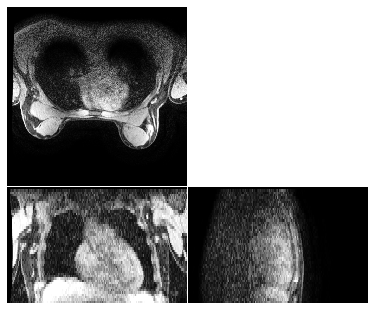

In [7]:
vis = ImageVisualiser(test_image, figure_size_in=5)
fig = vis.show()

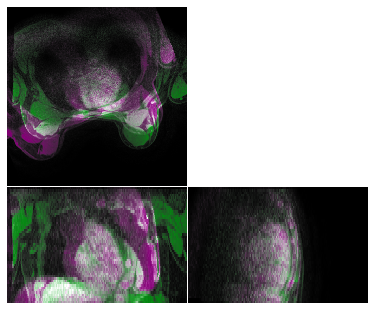

In [8]:
test_image_augmented, test_image_augmentation_transform = randomly_augment_image(test_image, scale_factor_bounds=1.1, maximum_rotation=0.1, maximum_translation_mm=10)

vis = ImageVisualiser(test_image, figure_size_in=5)
vis.add_comparison_overlay(test_image_augmented)
fig = vis.show()

In [9]:
# test_image_deformed, test_image_deformation_transform = randomly_deform_image(test_image, maximum_displacements_mm=1, peak_count=1, peak_width_mm=1000, default_value=0)

# vis = ImageVisualiser(test_image, figure_size_in=5)
# vis.add_comparison_overlay(test_image_deformed)
# vis.add_vector_overlay(test_image_deformation_transform.GetDisplacementField())
# fig = vis.show()

In [10]:
# doot = sitk.GetArrayFromImage(test_image_deformation_transform.GetDisplacementField())
# print(np.max(doot.flatten()))

In [11]:
# from shrimpy.augmentation import choose_random_displacement_rectangular, generate_smooth_peaked_vector_field, convert_mm_to_voxels_3d, generate_random_peaked_vector_field
# print(choose_random_displacement_rectangular())
# # doot = generate_smooth_peaked_vector_field((10,10,10), (5,5,5), (1,1,1))
# # print(doot)
# print(convert_mm_to_voxels_3d((10, 10, 10), test_image))
# noot = generate_random_peaked_vector_field((10,10,10), (3,3,3), peak_width_voxels=10)
# print(sum(noot.flatten() > 0.5))

[310.0159912109375, 310.0159912109375, 199.9998927116394]
(-145.96949768066406, 200.99400329589844, -66.97789764404297)
[155.00799561 155.00799561  99.99994636]
(512, 512, 50)
192


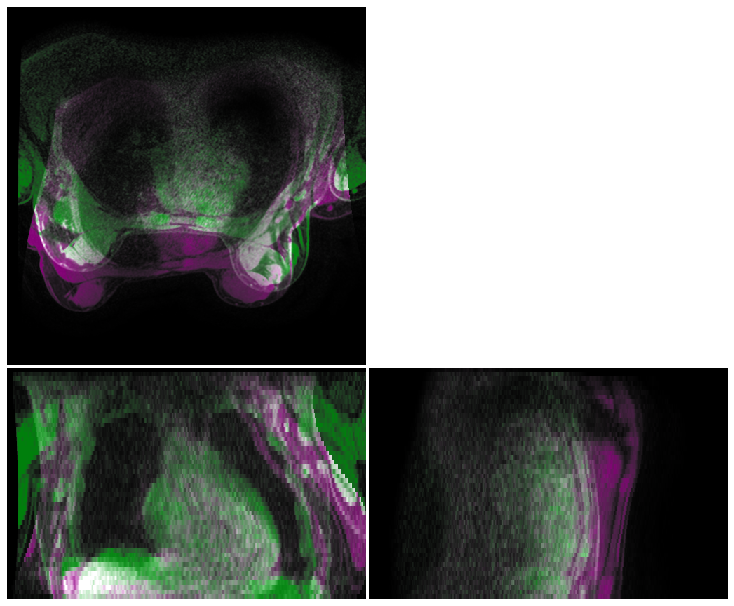

In [35]:
test_bspline = sitk.BSplineTransform(3, 2)
test_bspline.SetTransformDomainMeshSize((2, 2, 2))
physical_dimensions = [voxels*spacing for voxels, spacing in zip(test_image.GetSize(), test_image.GetSpacing())]
print(physical_dimensions)
print(test_image.GetOrigin())
print(np.array(physical_dimensions)/2)
print(test_image.GetSize())
test_bspline.SetTransformDomainPhysicalDimensions(physical_dimensions)
# test_bspline.SetTransformDomainPhysicalDimensions((4,4,4))
print(test_bspline.GetNumberOfParameters())
# test_bspline.SetTransformDomainOrigin(test_image.GetOrigin())
# test_bspline.SetTransformDomainOrigin(-np.array(physical_dimensions)/2+100)
test_bspline.SetTransformDomainOrigin((-146, -100, -67))
# test_bspline.SetTransformDomainOrigin((-159, -200, -69))
parameters = (rnd.random(test_bspline.GetNumberOfParameters())*2-1) * 100
test_bspline.SetParameters(parameters)

bsplined_image = apply_transform(
    input_image = test_image,
    reference_image = test_image,
    transform = test_bspline,
    default_value = 0,
    interpolator = sitk.sitkLinear
  )

vis = ImageVisualiser(test_image)
vis.add_comparison_overlay(bsplined_image)
fig = vis.show()

375


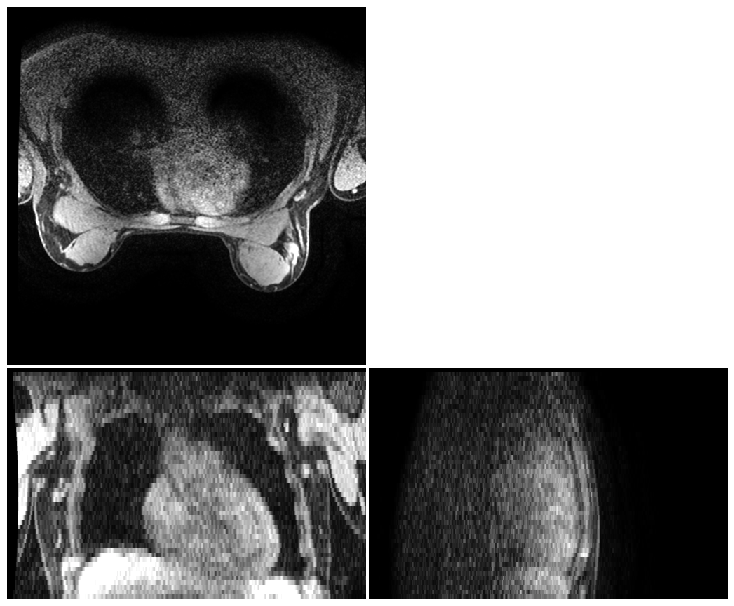

In [19]:
test_bspline = sitk.BSplineTransform(3, 3)
test_bspline.SetTransformDomainMeshSize((2, 2, 2))
physical_dimensions = [voxels*spacing for voxels, spacing in zip(test_image.GetSize(), test_image.GetSpacing())]
# print(physical_dimensions)
# print(test_image.GetOrigin())
# print(np.array(physical_dimensions)/2)
# print(test_image.GetSize())
test_bspline.SetTransformDomainPhysicalDimensions(physical_dimensions)
# test_bspline.SetTransformDomainPhysicalDimensions((4,4,4))
print(test_bspline.GetNumberOfParameters())
# test_bspline.SetTransformDomainOrigin(test_image.GetOrigin())
# test_bspline.SetTransformDomainOrigin(-np.array(physical_dimensions)/2+100)
test_bspline.SetTransformDomainOrigin((-146, -100, -67))
params = np.zeros(test_bspline.GetNumberOfParameters())
params[2] = 100
test_bspline.SetParameters(params)

# coefs = test_bspline.GetCoefficientImages()
# print(coefs[0].shape)
# coef_0_array = sitk.GetArrayFromImage(coefs[0])
# print(coef_0_array.shape)
# coef_0_array[2,2,2] = 100
# new_coefs = (sitk.GetImageFromArray(coef_0_array).CopyInformation(coefs[0]), coefs[1], coefs[2])
# # coefs[0] = sitk.GetImageFromArray(coef_0_array).CopyInformation(coefs[0])
# new_test_bspline = sitk.BSplineTransform(new_coefs, 3)
# test_bspline.SetTransformDomainPhysicalDimensions(physical_dimensions)
# test_bspline.SetTransformDomainOrigin((-146, -100, -67))

bsplined_image = apply_transform(
    input_image = test_image,
    reference_image = test_image,
    transform = test_bspline,
    default_value = 0,
    interpolator = sitk.sitkLinear
  )

vis = ImageVisualiser(test_image)
vis.add_comparison_overlay(bsplined_image)
fig = vis.show()

In [27]:
test_bspline = sitk.BSplineTransform(3, 3)
test_bspline.SetTransformDomainMeshSize((1, 1, 1))
physical_dimensions = [voxels*spacing for voxels, spacing in zip(test_image.GetSize(), test_image.GetSpacing())]
test_bspline.SetTransformDomainPhysicalDimensions(physical_dimensions)
test_bspline.SetTransformDomainOrigin((-146, -100, -67))
mean_squares = np.zeros(test_bspline.GetNumberOfParameters())
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMeanSquares()
for i in range(test_bspline.GetNumberOfParameters()):
    params = np.zeros(test_bspline.GetNumberOfParameters())
    params[i] = 100
    test_bspline.SetParameters(params)
    bsplined_image = apply_transform(
        input_image = test_image,
        reference_image = test_image,
        transform = test_bspline,
        default_value = 0,
        interpolator = sitk.sitkLinear
    )
    mean_squares[i] = registration_method.MetricEvaluate(test_image, bsplined_image)
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
